# Variables

In [1]:
import latenta as la

Modelling typically consists of several steps:
1. Creating known and unknown variables
2. Connect these variables in a graph structure
3. Infer the value of the unknown variables
4. Interpret the model

In this tutorial, we give a brief overview of the first two steps. More details on using latenta to interpret specific types of datasets can be found in the [tutorials](/tutorials), while detailed explanations on specific problems (e.g. the cell cycle) can be found in the [user guide](/guide).

We'll use a small single-cell transcriptomics dataset as demonstration:

In [2]:
import scanpy as sc

adata = sc.datasets.pbmc3k()

sc.pp.filter_cells(adata, min_counts = 100)

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.filter_genes_dispersion(adata)

sc.pp.pca(adata)
sc.pp.neighbors(adata)

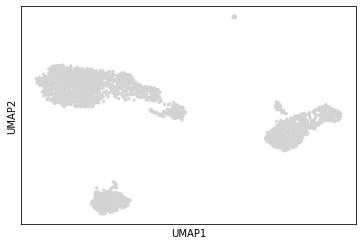

In [3]:
sc.tl.umap(adata)
sc.pl.umap(adata)

Just for demonstration, we'll focus on a broad clustering

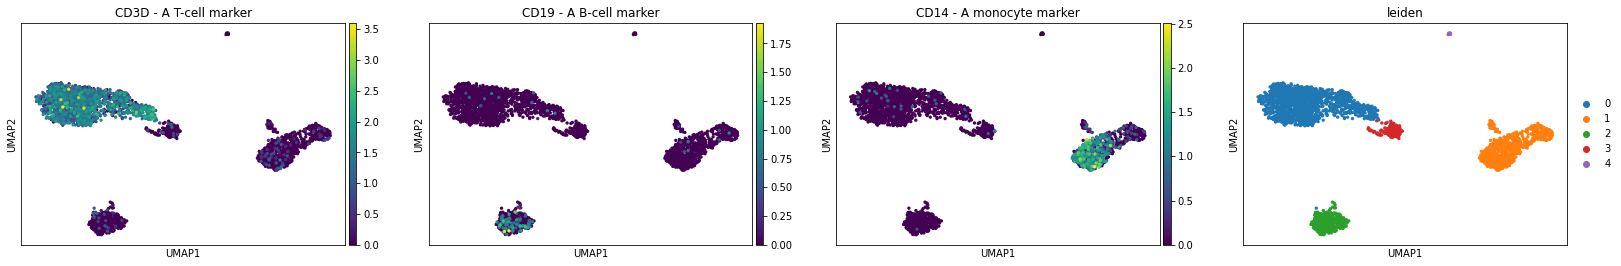

In [4]:
sc.tl.leiden(adata, resolution = 0.05)
sc.pl.umap(adata, color = ["CD3D", "CD19", "CD14", "leiden"], title = ["CD3D - A T-cell marker", "CD19 - A B-cell marker", "CD14 - A monocyte marker", "leiden"])

## Definition

A variable in latenta is a representation of a tensor, meaning it is a set of numbers that live in zero (scalar), one (vector), two (matrix) or more dimensions. Each dimension of a variable has coordinates (`.coords`), and identifier (`.id`). Furthermore,a dimension can also be annotation with a label, symbol and/or description.

A "genes" dimension could be defined as follows:

In [5]:
genes = la.Dim(adata.var.index, id = "gene")
genes

Dim gene

We can also simply provide a pandas series/index, although we have to take care to set the `index.name`:

In [ ]:
adata.var.index.name = "gene"
genes = la.Dim(adata.var.index)
genes

Similarly, for cells:

In [6]:
adata.obs.index.name = "cell"
cells = la.Dim(adata.obs.index, id = "cell")
cells

Dim cell

A count matrix is a prototypical example of a variable. We can define how it should look like, without any data, using {class}`la.Definition()`:

In [7]:
counts_definition = la.Definition(
    [cells, genes],
    "counts"
)
counts_definition

counts: Definition [cell (2700), gene (1041)]

## Fixed variables

Fixed variables contain a tensor that never changes:

In [8]:
counts = la.Fixed(adata.X, definition = counts_definition)

You can _run_ a variable by calling it's run function:

In [9]:
counts.run()

The value can be accessed as well. Because we're working with torch, this value is a `torch.tensor`:

In [10]:
counts.value

tensor([[0.0000, 0.0000, 0.0000,  ..., 1.3144, 2.3100, 1.8633],
        [0.0000, 0.0000, 0.0000,  ..., 1.7013, 3.2088, 1.8527],
        [0.5293, 0.0000, 0.0000,  ..., 0.8735, 0.8735, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.2835, 1.8275, 1.8275],
        [0.0000, 0.0000, 0.0000,  ..., 1.6660, 0.0000, 1.6660],
        [0.0000, 0.0000, 0.0000,  ..., 0.7452, 0.0000, 0.0000]])

Because our variable is annotated, we can also get this same value as a dataframe:

In [11]:
counts.value_pd.head()

gene,ISG15,TNFRSF4,CPSF3L,TNFRSF25,CTNNBIP1,RBP7,UBIAD1,EFHD2,CDA,MDS2,...,IFNGR2,MRPS6,DOPEY2,DSCR3,BRWD1,MX1,S100B,MT-ND2,MT-CO2,MT-ATP6
cell,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,0.000000,0.0,0.000000,1.034945,0.000000,0.0,0.0,0.645781,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.314376,2.310034,1.863283
AAACATTGAGCTAC-1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.370247,0.000000,0.370247,0.000000,0.0,1.701275,3.208782,1.852716
AAACATTGATCAGC-1,0.529264,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.529264,0.000000,0.000000,0.000000,0.000000,0.0,0.873535,0.873535,0.000000
AAACCGTGCTTCCG-1,2.139196,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.605688,1.252059,0.0,...,0.980213,0.000000,0.000000,0.000000,0.000000,0.605688,0.0,1.641433,1.920971,1.641433
AAACCGTGTATGCG-1,0.000000,0.0,0.000000,0.000000,1.175435,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,2.291224,0.0,0.491513,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.491513,0.000000,0.000000,0.491513,0.000000,1.066214,0.0,0.000000,1.263887,0.000000
TTTCTACTGAGGCA-1,0.493089,0.0,0.493089,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.821862,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.493089,0.000000
TTTCTACTTCCTCG-1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.283504,1.827533,1.827533


Do note that we can also provide pandas and xarray objects to {class}`Fixed`, and the definition of a variable will be inferred from the object's indices (if we gave them proper names).

In [12]:
cluster = la.Fixed((adata.obs["leiden"] == 0).astype(float), label = "cluster")
cluster

leiden:  ↦ Fixed [cell (2700)]

Note that we did not provide a definition to this variable, but it was inferred from the series you provided based on the index name (`adata.obs["leiden"].index.name`). The first dimensions of both our `counts` and `leiden` are therefore equal:

In [13]:
cluster[0] == counts[0]

True

For discrete fixed variables, we often like to work in a "one-hot" encoding, meaning that we get a binary (True/False) matrix if a sample (cell) is part of a particular group (cluster). We can use `la.discrete.DiscreteFixed` to do this conversion by providing it with a categorical pandas series:

```{margin}
A pandas categorical series is equivalent to R's factor
```

In [14]:
adata.obs["leiden"]

cell
AAACATACAACCAC-1    0
AAACATTGAGCTAC-1    2
AAACATTGATCAGC-1    0
AAACCGTGCTTCCG-1    1
AAACCGTGTATGCG-1    3
                   ..
TTTCGAACTCTCAT-1    1
TTTCTACTGAGGCA-1    2
TTTCTACTTCCTCG-1    2
TTTGCATGAGAGGC-1    2
TTTGCATGCCTCAC-1    0
Name: leiden, Length: 2700, dtype: category
Categories (5, object): ['0', '1', '2', '3', '4']

In [15]:
leiden = la.discrete.DiscreteFixed(adata.obs["leiden"])
leiden

leiden:  ↦ DiscreteFixed [cell (2700), leiden (5)]

In [16]:
leiden.run()
leiden.value_pd.head()

leiden,0,1,2,3,4
cell,,,,,
AAACATACAACCAC-1,1.0,0.0,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,1.0,0.0,0.0
AAACATTGATCAGC-1,1.0,0.0,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,1.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.0,1.0,0.0,0.0,0.0
TTTCTACTGAGGCA-1,0.0,0.0,1.0,0.0,0.0
TTTCTACTTCCTCG-1,0.0,0.0,1.0,0.0,0.0


## Parameters

Parameters are variables that are unknown and have to be inferred (optimized) based on our data. Parameters do require a starting default value.

In [17]:
lfc = la.Parameter(0., definition = la.Definition([genes]), label = "lfc", symbol = "lfc")
lfc

lfc:  ↦ Parameter [gene (1041)]

A combination of fixed and parameter variables form the leaves of our model. Any other types of variables in our models are ultimatily constructed from these leaf variables.

Although parameters are _free_, they can still have constraints. For example, the average expression of a gene can never go below zero, as this would be non-sensical. However, most algorithms cannot directly cope with these constraints and really like to work with parameters that can go from $-\infty$ to $+\infty$ (especially if you also want flexibility). We can solve this by transforming each parameter to make sure they fit our constraints.

Frequently used transformations are:

Description | Symbol | Transform | Description
--- | --- | --- | ----
All positive numbers | $R^+$ | `.Exp()` | $e^x$
Unit interval | $[0, 1]$ | `.Logistic()` | $\frac{1}{1+e^{-x}}$
Circular (i.e. an angle) | $[0, 2\pi[$ | `.Circular()` | atan2(y, x)

In [18]:
baseline = la.Parameter(
    1.,
    definition = la.Definition([genes]),
    label = "baseline",
    symbol = "baseline",
    transforms = [la.transforms.Exp()]
)
baseline

baseline:  ↦ Parameter [gene (1041)]

## Computed

We use variables to compute things. In this case we create a variable that depends on other variables, which we call components:

In [37]:
expression = la.links.scalar.Linear(cluster, a = lfc, label = "expression")

In [38]:
expression

expression: x, a ↦ Linear [cell (•), gene (•)] = $lfc \cdot x\require{action}$

Both dimensions of this variable are **broadcasted**, meaning that their coordinates and size are set by upstream components.

In [39]:
expression["cell"]

Dim cell

A critical tool when building complex models is to plot how different variables are related in the graph structure:


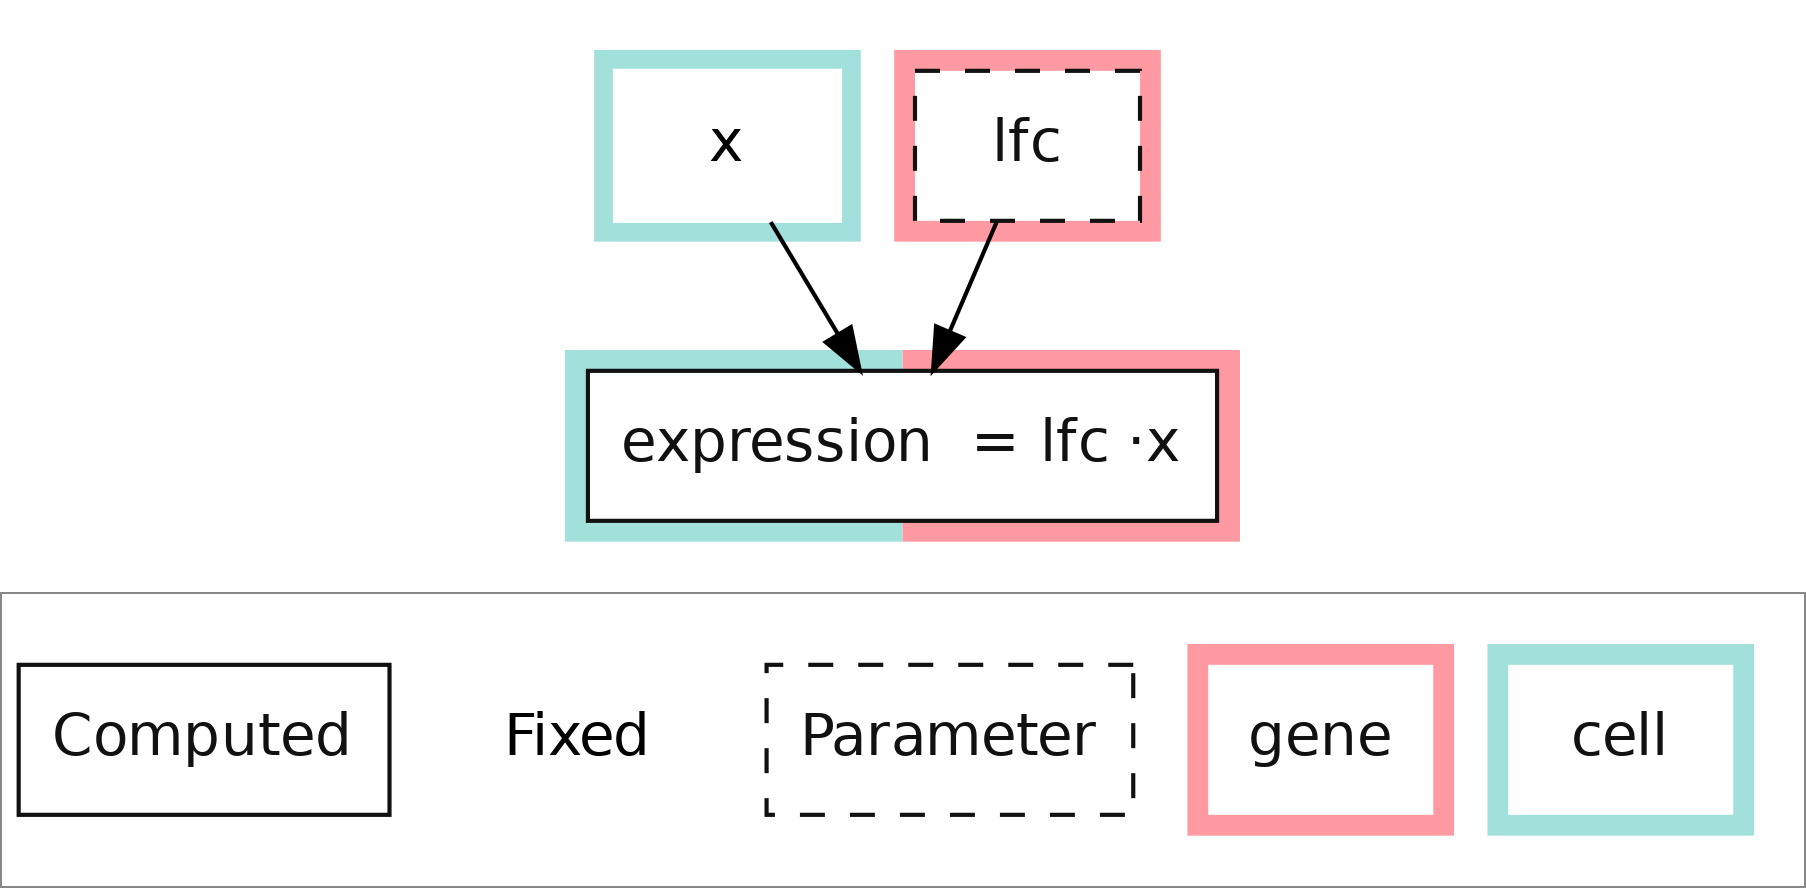

In [41]:
expression.plot()

:::{seealso}
Visualization and introspection of models is further discussed in the [guide](/guide/introspect)
:::

Components can be accessed using python's dot notation:

In [29]:
expression.a

lfc:  ↦ Parameter [gene (1041)]

We can sometimes also still add or change components after we have initialized the variable:

In [30]:
expression.b = baseline


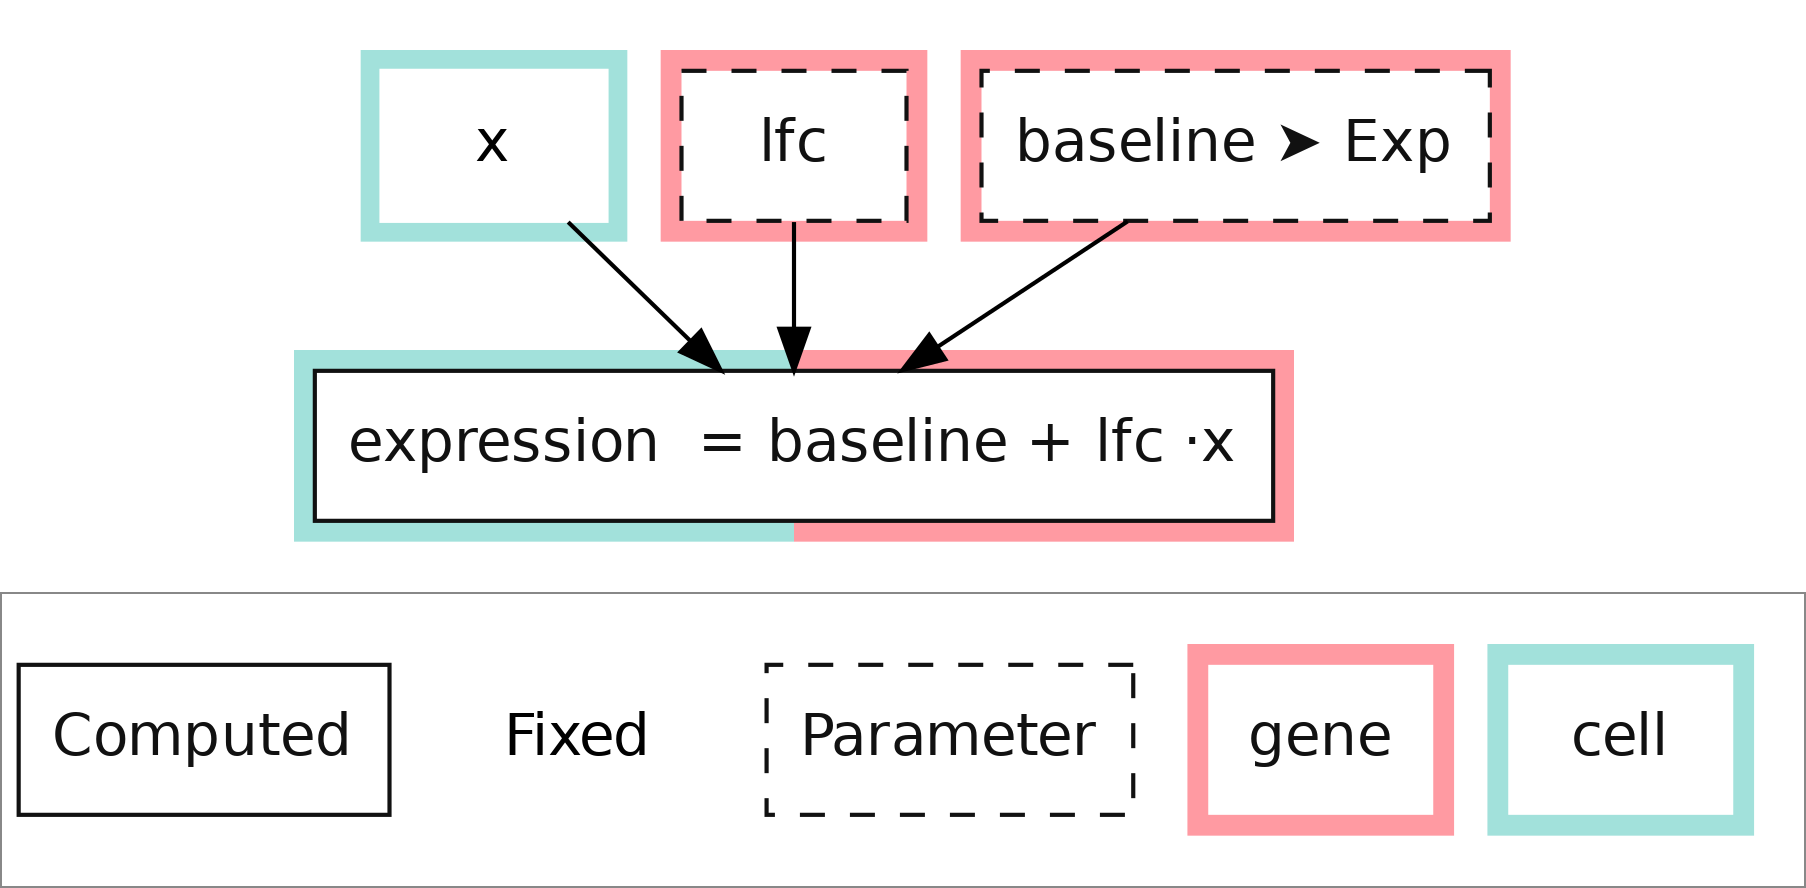

In [31]:
expression.plot()

Frequently occuring component names are:

Name | Component | Symbol | Description
--- | --- | --- | ----
Input | `.x` | $x$ | What you put into a computed variable
Coefficients, weight, slope | `.a` | $a$ | How much an input affects the output
Intercept,  bias | `.b` | $b$ | The baseline value of the output
Skew, rate | `.skew`, `.rate` | $\gamma$ or $\lambda$ | Scales the input
Shift | `.shift` | $\zeta$ | Shifts the input


## Distributions

We are often uncertain about the value of some variables, and this uncertainty is encoded as a distribution. A distribution has two characteristics:
- We can take a random sample. For example, we roll a dice and get 3
- We can calculate the probability of a particular sample, also known as the likelihood. For example, in a normal dice the probability of observing a 3 is 1/6

A lot of commonly used distributions have an _average_, also called a location, loc, mu or mean, and an _uncertainty_, also called the standard deviation, sigma, scale or dispersion.

Distributions often have the following components:

Name | Component | Symbol | Description
--- | --- | --- | ----
Location | `.loc` | $\mu$ | The mean, changing this parameter simply shifts the probability function
Mean | `.mu` | $\mu$ | The mean, in case it is not a location parameter
Scale | `.scale` | $\sigma$ | Measure of variability, changing this parameter simply scales the probability function
Dispersion | `.dispersion` | $\theta$ | Measure of variability, in case it is not a scale parameter
Probability | `.probs` | $p$ | A probability of success
Total counts | `.total_counts` | $n$ | Number of tries

Depending on the distribution, individual elements of a sample can be dependent. This dependence can be specific to particular dimensions. For example, if we would sample from a OneHotCategorical distribution, there can only be one 1 in every row:

A distribution we typically use for count data is a negative binomial, and more specifically the `NegativeBinomial2` variant that has two input parameters: the average count and the dispersion.

```{margin}
The naming conventions used are those from ProbOnto (https://sites.google.com/site/probonto/home) whenever available.
```

In [ ]:
counts = la.distributions.NegativeBinomial2(mu = expression)

In [ ]:
counts.run_recursive()
counts.value_pd.head()

Because we model an observation as a distribution, we can calculate how likely this observation is according to this distribution. The goal of any modelling is to maximize this likelihood, while remaining within the constraints imposed by the model.

In [ ]:
counts.likelihood

## Observations

Observations are fixed variables that follow a distribution. An observation always has some physical connection to reality, but the problem is that we only observe a noisy variant of this reality. This noise is not always purely technical (due to stochastic sampling of mRNAs) but also typically contains biological components (such as transcriptional bursting). Essentially, any variation that cannot be explained by the model is explained away as noise.

In [ ]:
observation = la.Observation(
    adata.X,
    counts,
    definition = counts_definition
)

observation.plot()

Running an observation does the same thing as running a fixed variable

In [ ]:
observation.run()

However, we can now also calculate the (log-)likelihood of the sample

In [ ]:
observation.likelihood

## Latent

Latent variables are unknown. but in contrast to a parameters they follow a distribution. Latent variables are central to probabilistic modelling, because they encompass two types of uncertainty:

### Uncertainty inherent to the system
::::{margin}
:::{note}
In general, we call this _aleatoric uncertainty_. In bayesian modelling, this type of uncertainty is typically encoded as the prior distribution.
:::
::::

Let's say we randomly take a cell from a tissue. Until we have observed something of this cell, we don't know anything what type of cell it is, except perhaps that some cell types are more likely because they are more abundant. This uncertainty is simply inherent to the population, and nothing we do can change that. We model this uncertainty an an appropriate probability distribution, which can have some known or unknown components.

This type of uncertainty is often of interest, and can provide some interesting biological information in more complex models. For example:
- How does cell type abundance change across different conditions?
- The distribution of all cell's pseudotime. Are there more early than late cells? Does this change between conditions?
- The distribution of the gene's fold changes. Are there more genes upregulated than downregulated? Are there a couple of genes with massive changes, while all other genes do not change at all?

### Uncertainty because of lack of data

::::{margin}
:::{note}
In general, we call this _epistemic uncertainty_. In bayesian modelling, this type of uncertainty is typically encoded as the posterior.
:::
::::
Let's say we focus on one particular cell, and we want to know it's celltype. Naturally, if we don't observe anything about this cell, our uncertainty will be the same as that inherent to the system as described above. However, if we would now observe some gene expression, our uncertainty for this particular cell will decrease. The more genes we observe, the more certain we will become.

This type of uncertainty is not inherent to the cell. The cell does not change its celltype just because we are uncertain about it. It therefore does not have a direct connection to reality, but is simply an artefact of us not knowing enough. Nonetheless, modelling this uncertainty is crucial because it gives us an idea about how certain we are about a variable. For example:
- We may be very certain about a cell's cell type, but are very uncertain about the cellular state. This could tell us that we don't have enough sequencing depth to assign a cell's state.
- If a gene's fold-change can be both negative, positive and close to 0, we know we don't have enough data. This doesn't mean the gene is not differentially expressed, it simply means we don't have enough data know whether it is.

:::{seealso}
https://en.wikipedia.org/wiki/Uncertainty_quantification#Aleatoric_and_epistemic_uncertainty
:::

### Constructing a latent variable

Latent variables combine both types of uncertainty:

Name | Component | Symbol | Description
--- | --- | --- | ----
Prior distribution | `.p` | $p$ | The distribution followed by the variable. Note that this distribution can depend on other parameters, latent or fixed variables.
Variational distribution | `.q` | $q$ | An approximation of the posterior distribution, i.e. the distribution followed by a variable after observing the data. The parameters of this distribution can be estimated directly (i.e. as one or more Parameter) or through the observed data using amortization

A prototypical example of a latent variable is the slope (i.e. fold-change) in a linear model:

In [ ]:
lfc_p = la.distributions.Normal(
    loc = 0.,
    scale = la.Parameter(1., transforms = [la.transforms.Exp()])
)
lfc = la.Latent(
    p = lfc_p,
    definition = la.Definition([genes])
)
expression = la.links.scalar.Linear(cluster, a = lfc, label = "expression")
expression.plot()

The prior distribution $p$ in this case is a normal distribution with one free parameter: the scale $\sigma$. This parameter determines how far the slope _on average_ can be different than 0. The only reason we can estimate this as a parameter is because we are pooling information across many genes. This kind of {term}`multi-level modelling` is very powerful, as it includes multiple testing correction directly within the model {citel}`gelman_why_2009`.

The variational distribution $q$ on the other hand contains two parameters both specific for each gene. These contain our idea of where the slope of a gene will lie: the location $\mu$ is the average, while the scale $\sigma$ our uncertainty.

Note that many link function allow you to automatically create a latent variable, although you have to provide the correct definition if some dimensions cannot be inferred from other components:

In [ ]:
expression = la.links.scalar.Linear(
    cluster,
    a = True,                                      # 👈
    label = "expression",
    definition = la.Definition([cells, genes])     # ⚠️
)
expression.plot()

:::{note}
Sometimes components of the prior distribution may themselves depend on a latent variable. In that case, this distribution will encompass both types of uncertainty. This would be the case for [most examples we gave for prior distributions](#uncertainty-inherent-to-the-system).
:::